In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the modified FOOOF library
from fooof import FOOOF

# Import libraries for reading, preprocessing and plotting
import os
import scipy.io
import numpy as np
from scipy.signal import welch
from scipy.signal.windows import hann
import matplotlib.pyplot as plt

In [3]:
# Define seetings for the Welch's method
Fs = 1000
welch_window = 1200
nfft_ = 4000

# Define colors for plotting
ap_colors = {
    'fixed': '#1D1DFF',       
    'flat_1exp': '#C00000',   
    '2exp': '#92E050',        
    '2exp_flat': '#FF6E00',  
    '3exp': '#FF40FF'    
}

In [4]:
# Define function to find the electrode of the tetrode which has the highest power
def maxpower(tetrodes, window, Fs, nfft_):
    f_range = [4, 495] # full range for power comparison
    total_power_per_electrode = np.zeros(4)
    for e in range(4):
        current_electrode = tetrodes[:, e].astype(np.float64)
        current_electrode[np.isnan(current_electrode)] = 0
        freqs, psd = welch(current_electrode, fs=Fs, window='hann', nperseg=window, noverlap=0.5*welch_window, nfft=nfft_)
        indices_in_range = (freqs >= f_range[0]) & (freqs <= f_range[1])
        power_in_range = np.sum(10 * np.log10(psd[indices_in_range]))
        total_power_per_electrode[e] = power_in_range
    max_electrode_index = np.argmax(total_power_per_electrode)
    hp_el = tetrodes[:, max_electrode_index]
    return hp_el

CA1_example.mat:


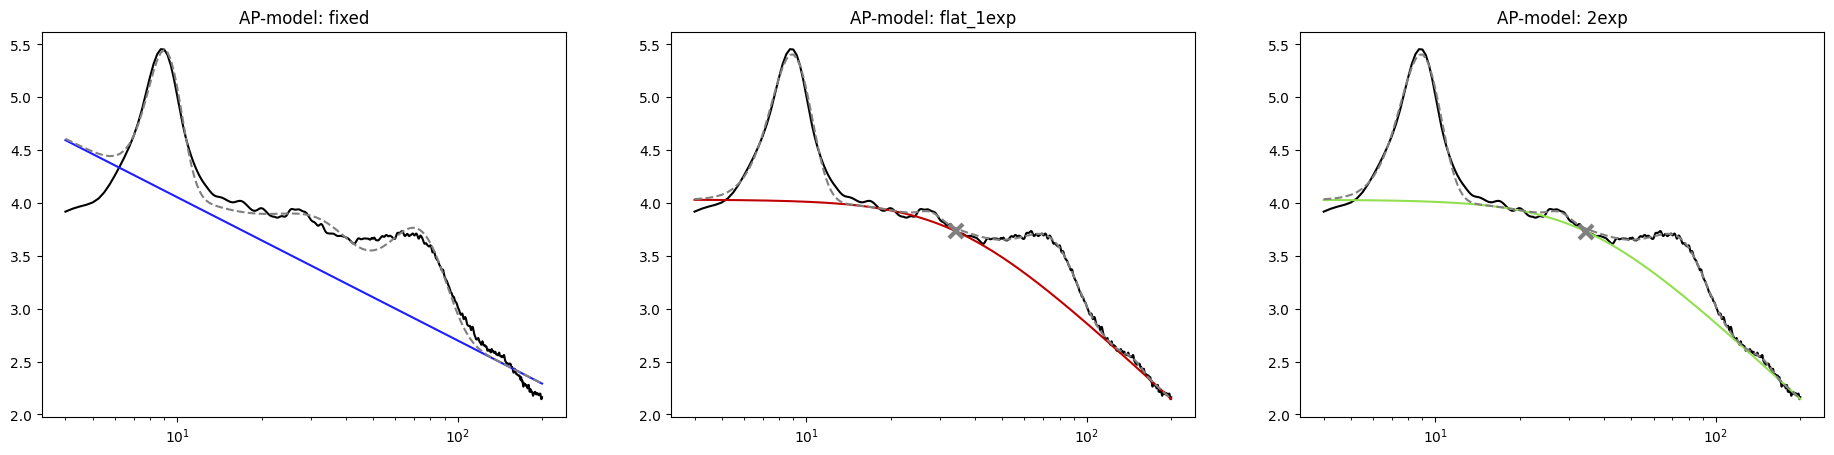

DG_example.mat:


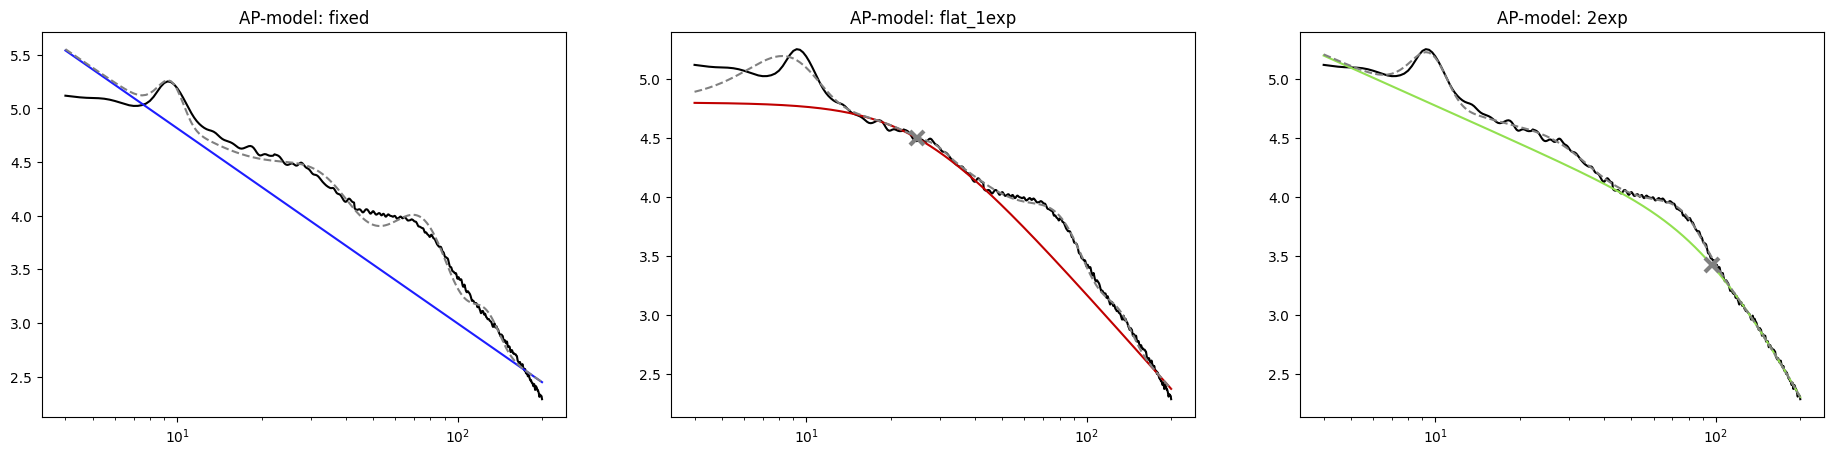

In [5]:
# Analyze data until 200Hz
ap_modes = ['fixed', 'flat_1exp', '2exp']
f_range = [4, 200]
subfolder = 'data'
example_data = [f for f in os.listdir(subfolder)]
for dataset in example_data:
    print(f"{dataset}:")
    path = os.path.join(subfolder, dataset)  
    tetrode = scipy.io.loadmat(path)['mlfp'].astype('<i2') # Read in tetrode data
    hp_electrode = maxpower(tetrode, welch_window, Fs, nfft_) # Select highest power electrode
    freqs, psd = welch(hp_electrode, window='hann', nperseg=welch_window, noverlap=0.5*welch_window, fs=Fs, nfft = nfft_)

    # Compare apropriate aperiodic models until 200Hz
    fig, axes = plt.subplots(1, 3, figsize=(23, 5))
    for ap_mode, axis in zip(ap_modes, axes):
        # Create and fit FOOOF object
        fm = FOOOF(aperiodic_mode=ap_mode, verbose=False)
        fm.add_data(freqs, psd, freq_range=[f_range[0], f_range[1]])
        fm.fit()
        axis.semilogx(fm.freqs, fm.power_spectrum, color='black')
        axis.semilogx(fm.freqs, fm.ap_fit, color = ap_colors[ap_mode])
        axis.semilogx(fm.freqs, fm.fooofed_spectrum_, color='gray', linestyle='--')
        axis.set_title(f'AP-model: {ap_mode}')

        # Visualize knee frequency:
        if ap_mode != 'fixed':
            knee_freq = fm.aperiodic_params_[1]
            closest_index = np.abs(fm.freqs - knee_freq).argmin() # Find power at knee frequency
            knee_power_value = fm.ap_fit[closest_index]
            axis.plot(knee_freq, knee_power_value, color='gray', marker='x', markersize=10, markeredgewidth=3)

    plt.show()   

The '2exp' works best for this range ('flat_1exp' also works well for CA1). However these models are insufficient to fit the whole spectrum, as they don't considers the flattening of the spectrum.
The '2exp-flat' or '3exp' model might work better when fitting the whole range:

CA1_example.mat:


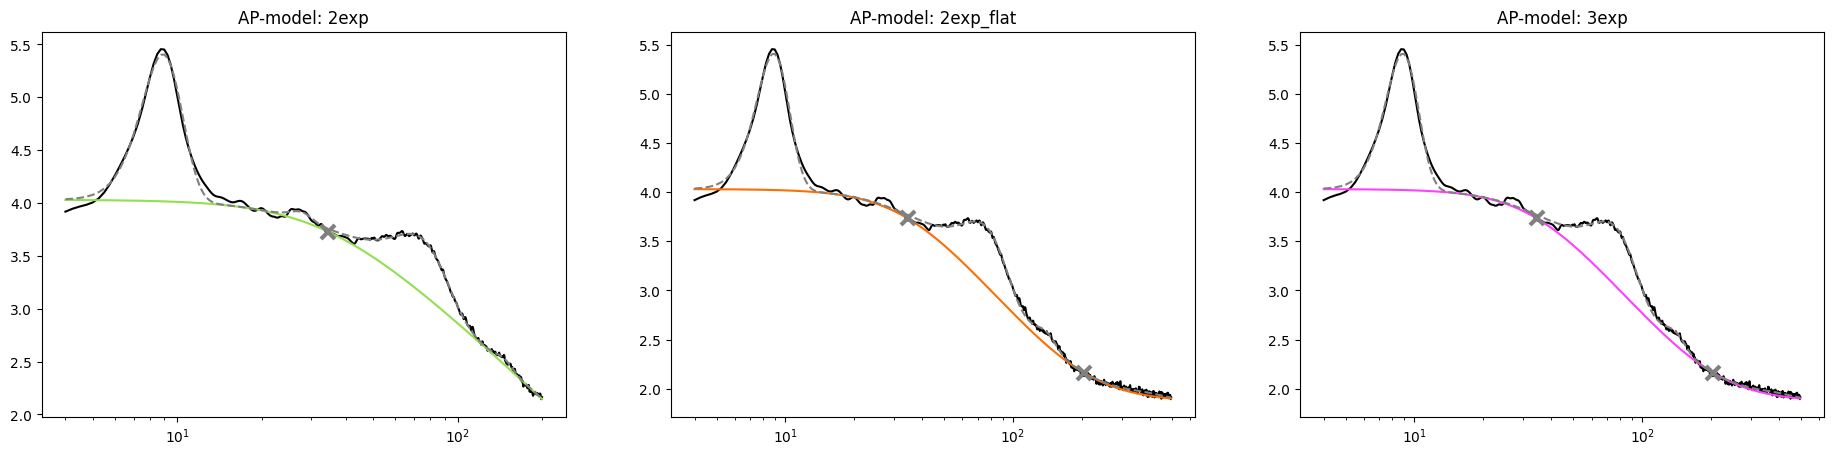

DG_example.mat:


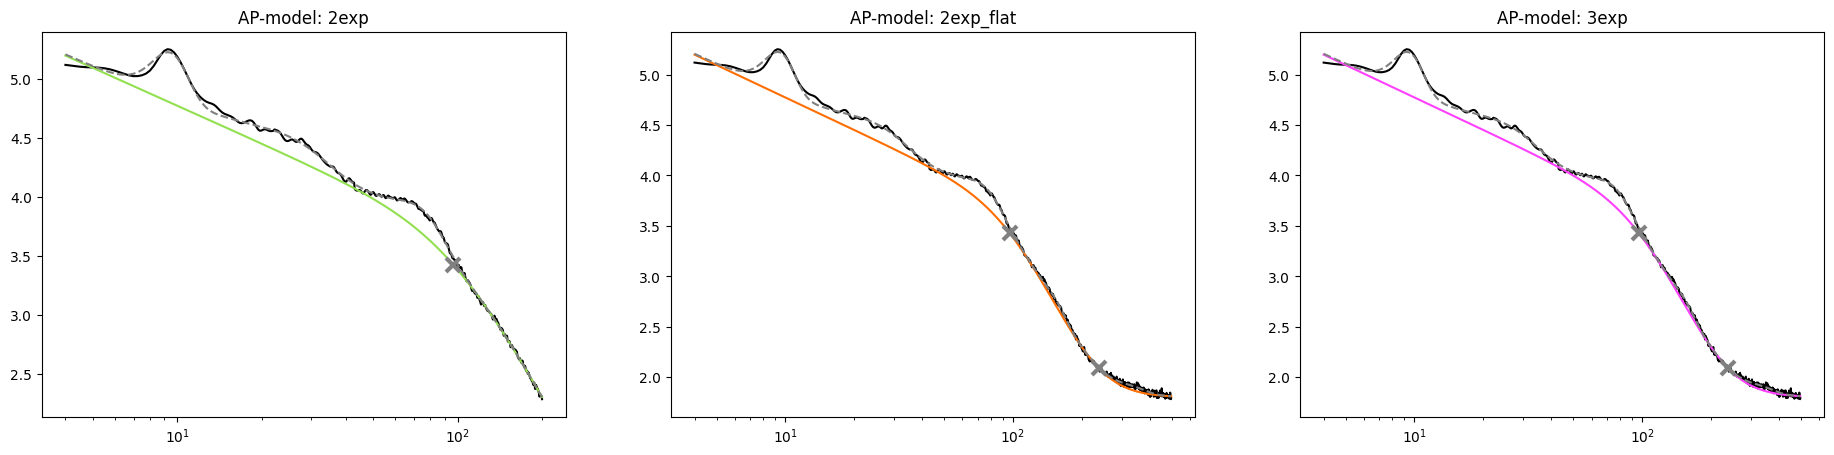

In [6]:
# Analyze data until 495Hz
ap_modes = ['2exp', '2exp_flat', '3exp']
f_range = [4, 495]
subfolder = 'data'
example_data = [f for f in os.listdir(subfolder)]
for dataset in example_data:
    print(f"{dataset}:")
    path = os.path.join(subfolder, dataset)  
    tetrode = scipy.io.loadmat(path)['mlfp'].astype('<i2') # Read in tetrode data
    hp_electrode = maxpower(tetrode, welch_window, Fs, nfft_) # Select highest power electrode
    freqs, psd = welch(hp_electrode, window='hann', nperseg=welch_window, noverlap=0.5*welch_window, fs=Fs, nfft = nfft_)

    # Do an intitial fit until 200Hz (optional for fixating parameters)
    prefit = FOOOF(aperiodic_mode='2exp', verbose=False)
    prefit.add_data(freqs, psd, freq_range=[4, 200])
    prefit.fit()
    pre_ap = prefit.aperiodic_params_
    
    # Compare apropriate aperiodic models until 495Hz
    fig, axes = plt.subplots(1, 3, figsize=(23, 5)) 
    for ap_mode, axis in zip(ap_modes, axes):
        if ap_mode == '2exp':
            axis.semilogx(prefit.freqs, prefit.power_spectrum, color='black')
            axis.semilogx(prefit.freqs, prefit.ap_fit, color = ap_colors[ap_mode])
            axis.semilogx(prefit.freqs, prefit.fooofed_spectrum_, color='gray', linestyle='--')
            axis.set_title(f'AP-model: {ap_mode}')

             # Visualize knee frequency:
            knee_freq = prefit.aperiodic_params_[1]
            closest_index = np.abs(prefit.freqs - knee_freq).argmin() # Find power at knee frequency
            knee_power_value = prefit.ap_fit[closest_index]
            axis.plot(knee_freq, knee_power_value, color='gray', marker='x', markersize=10, markeredgewidth=3)
        else:
            fm = FOOOF(aperiodic_mode=ap_mode, verbose=False)
            #Optionally, some parameters can be fixed to prevent overfitting:
            fm.add_data(freqs, psd, freq_range=[f_range[0], f_range[1]], off_fix = pre_ap[0], knee_fix = pre_ap[1], exp1_fix = pre_ap[2])
            fm.fit()
            axis.semilogx(fm.freqs, fm.power_spectrum, color='black')
            axis.semilogx(fm.freqs, fm.ap_fit, color = ap_colors[ap_mode])
            axis.semilogx(fm.freqs, fm.fooofed_spectrum_, color='gray', linestyle='--')
            axis.set_title(f'AP-model: {ap_mode}')
            
            # Visualize flattening frequency
            flat_freq = fm.aperiodic_params_[2]
            closest_index = np.abs(fm.freqs - flat_freq).argmin() # Find power at flat frequency
            flat_power_value = fm.ap_fit[closest_index]
            axis.plot(flat_freq, flat_power_value, color='gray', marker='x', markersize=10, markeredgewidth=3)
            
            # Visualize knee frequency:
            knee_freq = fm.aperiodic_params_[1]
            closest_index = np.abs(fm.freqs - knee_freq).argmin() # Find power at knee frequency
            knee_power_value = fm.ap_fit[closest_index]
            axis.plot(knee_freq, knee_power_value, color='gray', marker='x', markersize=10, markeredgewidth=3)

    plt.show()